<h2>Import all the Dependencies</h2>

In [118]:
import tensorflow as tf

In [119]:
from tensorflow.keras import models,layers

In [120]:
import matplotlib.pyplot as plt

<h2>Set all the Constants</h2>

In [121]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 
EPOCHS=50

<h2>Import data into tensorflow dataset object</h2>

<p>We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory</p>

In [122]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [123]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [124]:
len(dataset)

68

<h1>Visualize some of the images from our dataset</h1>

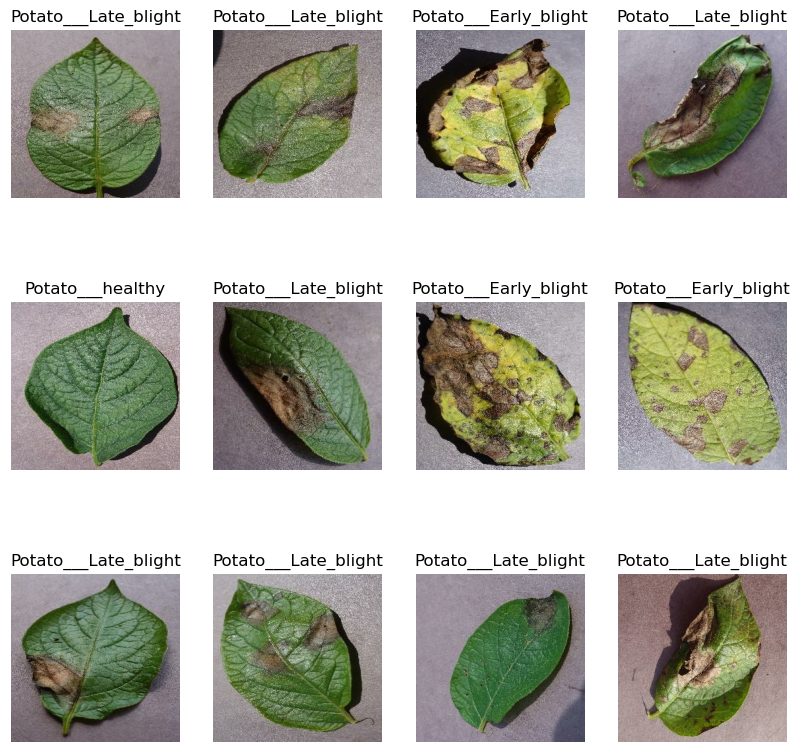

In [125]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<h2>Function to Split Dataset</h2>
<p>
Dataset should be divided into 3 subsets, namely:
<ol>
1.) Training(80%): Dataset to be used while training<br>
2.)Validation(10%): Dataset to be tested against while training<br>
3.)Test(10%): Dataset to be tested against after we trained a model<br>
</ol>
</p>

In [126]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [127]:
train_ds = dataset.take(54)
len(train_ds)

54

In [128]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [129]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [130]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [131]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [132]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [133]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [134]:
len(train_ds)

54

In [135]:

len(val_ds)

6

In [136]:

len(test_ds)

8

<h2>Cache, Shuffle, and Prefetch the Dataset</h2>

In [137]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h1>Building the Model</h1>

<h2>Creating a Layer for Resizing and Normalization</h2>

<p>
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
</p>
<p>
Why do we need to resize (256,256) image to again (256,256)?<br>
We don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.
</p>
    

In [138]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

<h1>Data Augmentation</h1>

<h3>Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.</h3>

In [139]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

<h2>Applying Data Augmentation to Train Dataset</h2>

In [140]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

<h1>Model Architecture</h1>

<p>We use a CNN coupled with a Softmax activation in the output layer. <br>We also add the initial layers for resizing, normalization and Data Augmentation.</p>

In [141]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [142]:

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)        

<h2>Compiling the Model</h2>

<p>We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric</p>

In [143]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [144]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 58s 1s/step - loss: 0.9079 - accuracy: 0.4693 - val_loss: 0.8611 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 48s 889ms/step - loss: 0.7728 - accuracy: 0.5984 - val_loss: 0.4340 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 46s 852ms/step - loss: 0.4744 - accuracy: 0.7818 - val_loss: 0.2966 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 46s 845ms/step - loss: 0.3755 - accuracy: 0.8443 - val_loss: 0.3096 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 46s 856ms/step - loss: 0.2934 - accuracy: 0.8825 - val_loss: 0.2420 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 46s 849ms/step - loss: 0.2512 - accuracy: 0.8935 - val_loss: 0.1965 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 47s 863ms/step - loss: 0.2107 - accuracy: 0.9167 - val_loss: 0.3831 - val_accuracy: 0.8490
Ep

In [145]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 359ms/step - loss: 0.2041 - accuracy: 0.9336


In [146]:
scores


[0.20413526892662048, 0.93359375]

<h3>We get 93.3% accuracy for our test dataset.</h3>

<h1>Plotting the Accuracy and Loss Curves</h1>

In [147]:
history

In [148]:

history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [149]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<p>Loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch</p>

In [150]:
type(history.history['loss'])

list

In [151]:
len(history.history['loss'])

50

In [152]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9078905582427979,
 0.7727881669998169,
 0.47442764043807983,
 0.3754807114601135,
 0.2934306263923645]

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

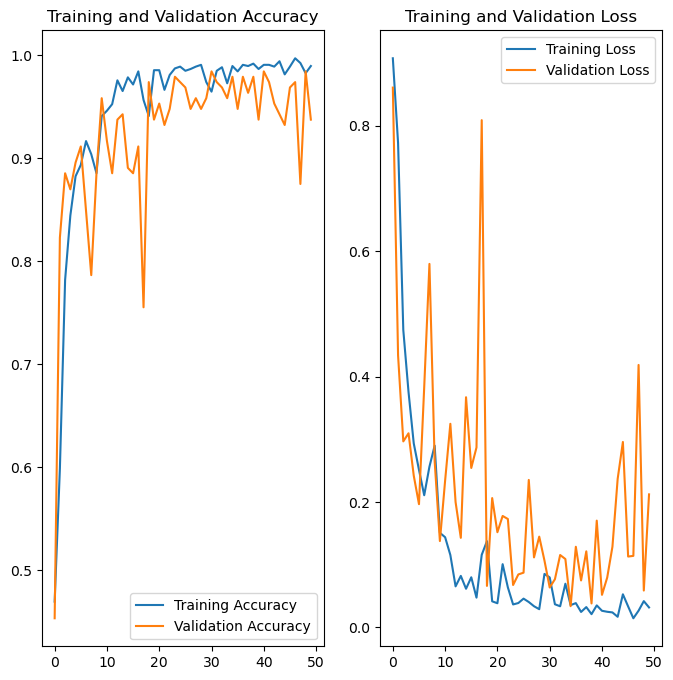

In [154]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2>Run prediction on a sample image</h2>

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


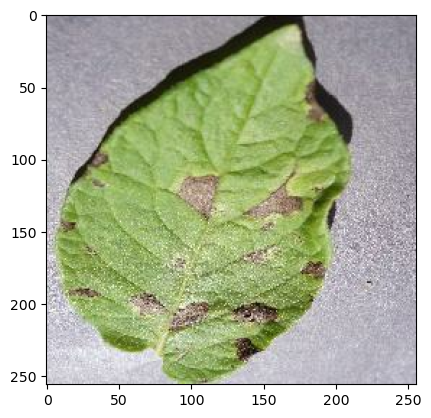

In [155]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

<h2>Write a function for inference</h2>

In [156]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

<h2>Now run inference on few sample images</h2>

1/1 [==============================] - 0s 41ms/step


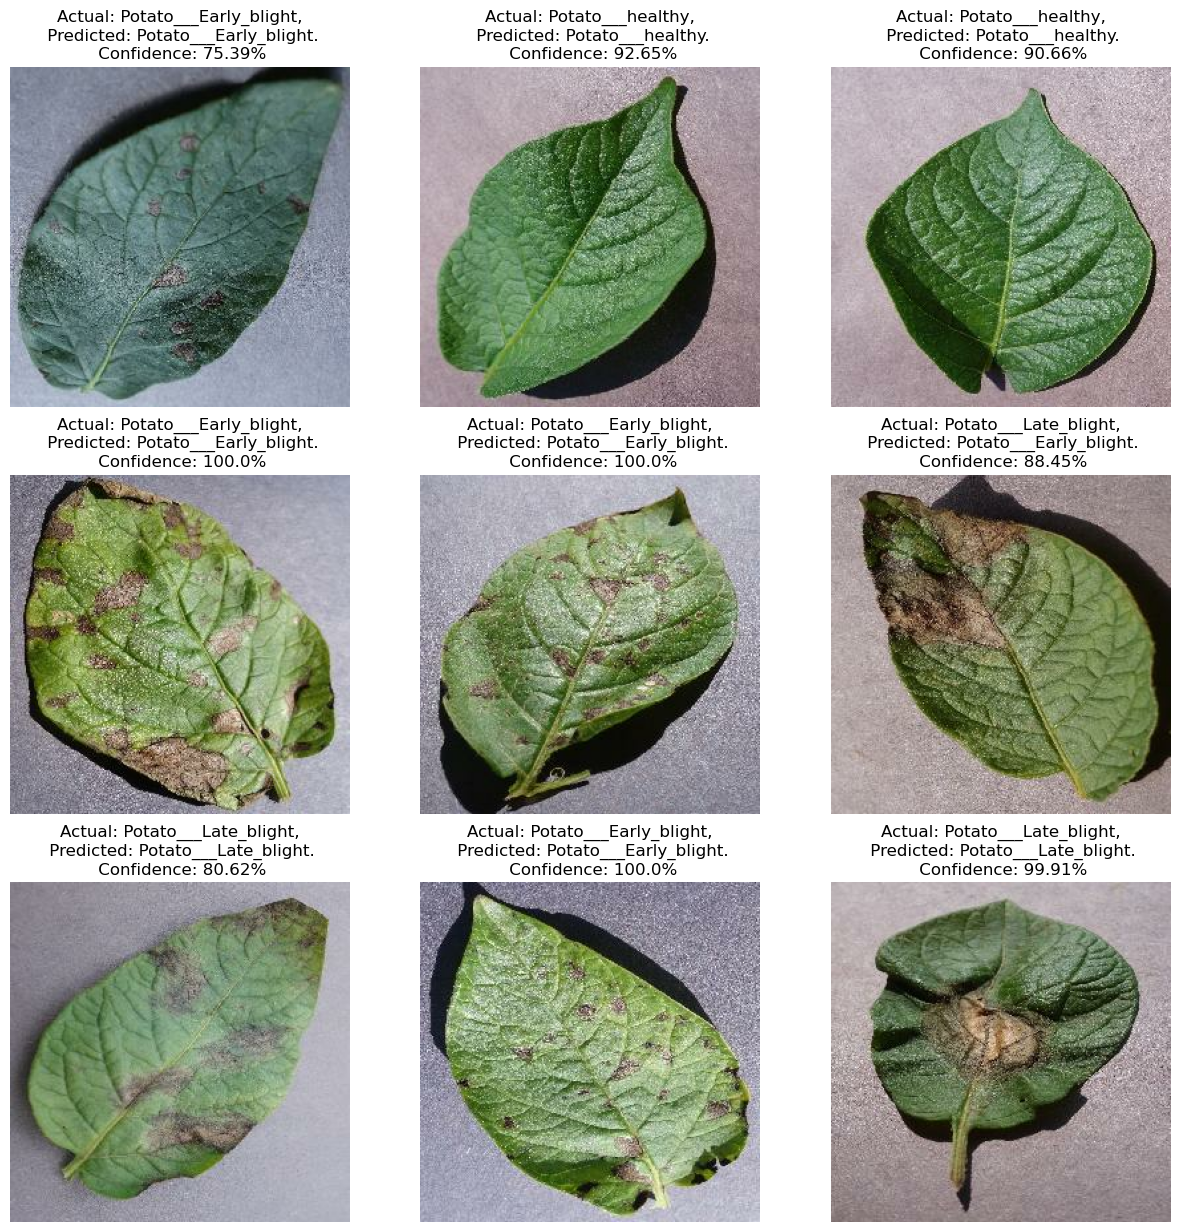

In [157]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

<h1>Saving the Model</h1>

<h4>We append the model to the list of models as a new version</h4>

In [163]:
import os 
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets


In [161]:
model.save("../potatoes.h5")

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
